## Supervised Learning

**ESL.mixture.rda Dataset**

In [ ]:
"""
These are the data used in Figures 2.1-2.3, and elsewhere through the
book. 
The data are in the R data object:
ESL.mixture.rda
which you read in using load("ESL.mixture.rda")

The components are:

x	       200 x 2 matrix of training predictors
y	       class variable; logical vector of TRUES and 
	       FALSES - 100 of each
xnew	       matrix 6831 x 2 of lattice points in predictor space
prob	       vector of 6831 probabilities (of class TRUE) at each 
	       lattice point
marginal       marginal probability at each lattice point
px1	       69 lattice coordinates for x.1
px2	       99 lattice values for x.2  (69*99=6831)
means	       20 x 2 matrix of the mixture centers, first ten for one
	       class, next ten for the other

So for example, the Bayes error rate is computed as
bayes.error<-sum(marginal*(prob*I(prob<0.5)+(1-prob)*I(prob>=.5)))

If pred is a vector of predictions (of the logit, say):
pred<-predict.logit(xnew)
then the test error is 
test.error<-sum(marginal*(prob*I(pred <0)+(1-prob)*I(pred>=0)))
"""

### Linear Regression 
- book: linear model in classification context

In [ ]:
from google.colab import files 
files.upload() 

In [1]:
import numpy as np
import pandas as pd
import math, os, random 
from matplotlib import pyplot as plt 
%matplotlib inline 

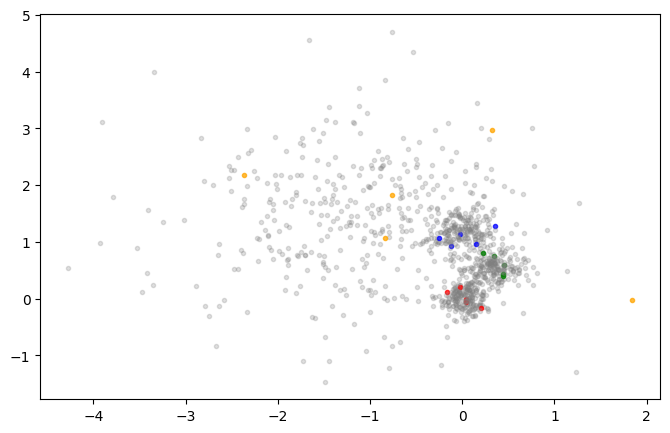

In [5]:
""" utility source code Stanford ML - with modifications """ 
COLORS = ['red', 'green', 'blue', 'orange']
DATA_DIR = '.'
MAX_LABELED = 5   # Max number of points to label per cluster
UNLABELED = -1    # Cluster label for unlabeled data points

def generate_gaussian(num_examples=100):
    """Generate dataset where each example is sampled 
    from 1 of 4 bivariate Gaussians """
    # Set parameters for each Gaussian in the mixture
    gaussians = [ 
        ([0.0, .00], .02 * np.eye(2), 200), ([.35, .55], .03 * np.eye(2), 200),
        ([0.0, 1.2], .04 * np.eye(2), 200), ([-1., 1.4], 1.0 * np.eye(2), 400),]
    # Generate dataset
    examples = []
    for class_idx, (mu, sigma, count) in enumerate(gaussians):
        # Sample class from Gaussian
        class_examples = np.random.multivariate_normal(mu, sigma, count)
        # Add each example to the list
        n_labeled = 0
        for x in class_examples:
            x_dict = {'x_{}'.format(i+1): x_i for i, x_i in enumerate(x)}

            # Only label MAX_LABELED per class
            if n_labeled < MAX_LABELED:
                x_dict['z'] = class_idx
                n_labeled += 1
            else:
                x_dict['z'] = UNLABELED
            examples.append(x_dict)
    random.shuffle(examples)
    df = pd.DataFrame(examples)

    return df

def plot_dataset(df, output_path):
    """Plot a 2D dataset and write to output_path."""
    x = np.array([[row['x_1'], row['x_2']] for _, row in df.iterrows()])
    z = np.array([row['z'] for _, row in df.iterrows()])
    plt.figure(figsize=(8, 5))
    for x_1, x_2, z_ in zip(x[:, 0], x[:, 1], z):
        color = 'gray' if z_ < 0 else COLORS[int(z_)]
        alpha = 0.25 if z_ < 0 else 0.75
        plt.scatter(x_1, x_2, marker='.', c=color, alpha=alpha)
    #plt.savefig(output_path)
    plt.show()

np.random.seed(229)
random.seed(229)
for split, n in [('train', 1000), ('valid', 44), ('test', 48)]:
  gaussian_df = generate_gaussian(num_examples=n)
  gaussian_df.to_csv(os.path.join(DATA_DIR, '{}.csv'.format(split)), index=False)
  if split == 'train':
    plot_dataset(gaussian_df, os.path.join(DATA_DIR, 'plot.eps'))

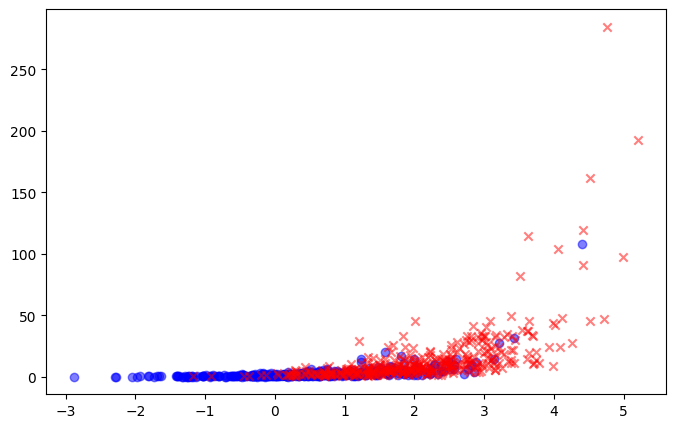

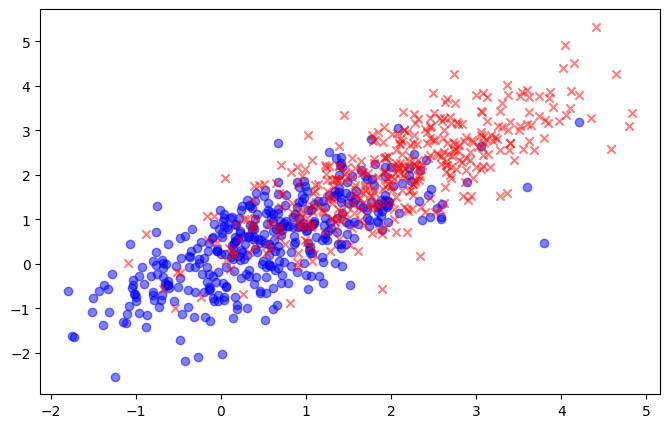

In [4]:
def generate_gaussian_b(num_examples=100, exponentiate=False):
  """ Generate dataset where each class is sampled from a bivariate Gaussian """
  # Set parameters for each class
  class_labels = (0., 1.)
  mus = ([0.5, 0.5], [2, 2])
  sigmas = ([[1, 0.75], [0.75, 1]], [[1, 0.75], [0.75, 1]])
  # Generate dataset
  examples = []
  for class_label, mu, sigma in zip(class_labels, mus, sigmas):
    # Sample class from Gaussian
    class_examples = np.random.multivariate_normal(
        mu, sigma, num_examples // len(class_labels))
    # Add each example to the list
    for x in class_examples:
      x_dict = {f'x_{i+1}': x_i for i, x_i in enumerate(x)}
      x_dict['y'] = class_label
      if exponentiate:
        x_dict['x_2'] = math.exp(x_dict['x_2'])
      examples.append(x_dict)
  df = pd.DataFrame(examples)

  return df

def plot_dataset_b(df, output_path):
  """ Plot a 2D dataset and write to output_path """
  xs = np.array([[row['x_1'], row['x_2']] for _, row in df.iterrows()])
  ys = np.array([row['y'] for _, row in df.iterrows()])
  plt.figure(figsize=(8, 5))
  for x_1, x_2, y in zip(xs[:, 0], xs[:, 1], ys):
    marker = 'x' if y > 0 else 'o'
    color = 'red' if y > 0 else 'blue'
    plt.scatter(x_1, x_2, marker=marker, c=color, alpha=.5)
  #plt.savefig(output_path)
  plt.show()

for split, n in [('train', 800), ('valid', 100), ('test', 101)]:
  non_gaussian_df = generate_gaussian_b(num_examples=n, exponentiate=True)
  non_gaussian_df.to_csv(os.path.join(DATA_DIR, f'ds1_{split}.csv'), index=False)
  if split == 'train':
      plot_dataset_b(non_gaussian_df, os.path.join(DATA_DIR, 'plot1.png'))

# ds2 is Gaussian
for split, n in [('train', 800), ('valid', 100), ('test', 101)]:
  gaussian_df = generate_gaussian_b(num_examples=n, exponentiate=False)
  gaussian_df.to_csv(os.path.join(DATA_DIR, f'ds2_{split}.csv'), index=False)
  if split == 'train':
    plot_dataset_b(gaussian_df, os.path.join(DATA_DIR, 'plot2.png'))

In [ ]:
""" Dataset 
10 means mk were drawn from a bivariate Gaussian distribution ((1, 0), I)
10 more were drawn ((0, 1), I)
for each class 100 observation generated
  - mk picked at random, with probability 1/10 
observation drawn from (mk, I/5) leading to a mixture of Gaussian cluster 
for each class 

We are going to work with classifiers and use commonly used colors
"""

In [ ]:
""" 
x	       200 x 2 matrix of training predictors
y	       class variable; logical vector of TRUES and 
""" 
dataset_mixture = pd.read_csv('mixture_x_y.csv', names=['x1', 'x2', 'y'])
dataset_mixture, 

(           x1        x2  y
 0    2.526093  0.321050  0
 1    0.366954  0.031462  0
 2    0.768219  0.717486  0
 3    0.693436  0.777194  0
 4   -0.019837  0.867254  0
 ..        ...       ... ..
 195  0.256750  2.293605  1
 196  1.925173  0.165053  1
 197  1.301941  0.992200  1
 198  0.008131  2.242264  1
 199 -0.196246  0.551404  1
 
 [200 rows x 3 columns],)

In [ ]:
gray_, gray__, purple_, blue_, blue__, orange_= \
        "#231F20", "#646379", "#A021F1", '#57B5E8', '#bdd7e7', '#E69E00'

In [ ]:
X_train = dataset_mixture[['x1', 'x2']].values
y_train = dataset_mixture['y'].values
X_train[:5], y_train[:5]

(array([[ 2.52609297,  0.32105045],
        [ 0.36695447,  0.0314621 ],
        [ 0.76821908,  0.71748617],
        [ 0.69343568,  0.77719403],
        [-0.01983662,  0.86725374]]),
 array([0, 0, 0, 0, 0]))

In [ ]:
""" set the clusters means """ 
cluster1_means = np.array([
      [-0.25713628, 1.085183909],  [0.267442252, 0.362826378], 
      [2.126868516, 1.154179996],  [-0.079583353, 0.323311979],
      [2.710763558, 0.876644795],  [2.34276551, 0.358477769], 
      [1.053188784, -0.903565594], [0.574290652, -0.454657409],
      [0.659906227, -1.241636702], [1.642844649, -0.283878559] ])
cluster2_means = np.array([
      [1.126644806, 0.665912397], [-0.313007477, 1.273747315],
      [0.056184431, 2.519258089], [1.301202425, 0.725799603],
      [-0.07129517, 1.460543433], [3.50312646, 1.223981852],
      [1.61321271, 1.860080951],  [1.028464289, 1.550985579],
      [-0.487292651, 0.979110495], [-1.79628661, 0.771731486] ])
all_means = np.vstack((cluster1_means, cluster2_means))

In [ ]:
""" gausian mixture requires a fit to work even with means and covariances known """ 
from sklearn.mixture import GaussianMixture
from sklearn.mixture._gaussian_mixture import _compute_precision_cholesky
from sklearn.metrics import accuracy_score

_gaussian_mixture_model = GaussianMixture(
    n_components=20, covariance_type='spherical', means_init=all_means, 
    random_state=1).fit(all_means)
_gaussian_mixture_model.covariances_ = [1/5]*20
_gaussian_mixture_model.precisions_cholesky_ = _compute_precision_cholesky(
    _gaussian_mixture_model.covariances_, _gaussian_mixture_model.covariance_type)

""" sample data points for testing, subset for y testing and index on criteria""" 
X_test, y_test = _gaussian_mixture_model.sample(10000)
y_test = 1*(y_test>=10)

""" with the known distribution from the data sampled, we build the 
Optimized Bayes classifier and find the error rate """ 
def optimal_bayes_predict(X): # (X, gaussian_model)
  components_proba = _gaussian_mixture_model.predict_proba(X)
  proba_set1 = np.sum(components_proba[:, :10], axis=1)
  proba_set2 = np.sum(components_proba[:, 10:], axis=1)
  y_predict = 1*(proba_set1 < proba_set2)
  return y_predict

y_predict = optimal_bayes_predict(X_test) # (X_test, _gaussian_mixture_model)

bayes_error_rate = 1 - accuracy_score(y_test, y_predict)
print('Bayes Error rate', bayes_error_rate)

Bayes Error rate 0.1604


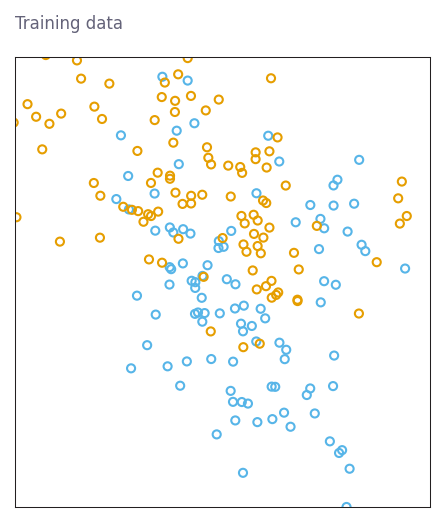

In [ ]:
def plot_training_data(title):
  figure, ax = plt.subplots(figsize=(3, 3), dpi=150)
  ax.set_aspect(1.5)
  ax.scatter(X_train[:, 0], X_train[:, 1], s=15, facecolors='none', 
            edgecolors=np.array([blue_, orange_])[y_train])
  ax.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
  ax.set_xlim(-2.5, 4) ; ax.set_ylim(-2, 2.7)
  figure.subplots_adjust(left=0, right=1, top=1, bottom=0)
  ax.text(-2.5, 3, title, color=gray__, fontsize=8)
  for spine in ax.spines.values(): spine.set_color(gray_)
  
  return figure, ax

_, _ = plot_training_data('Training data') 

In [ ]:
n1, n2 = 69, 99
x1 = np.linspace(-3, 4, n1) 
x2 = np.linspace(-2, 2.5, n2)
X = np.transpose([np.tile(x1, n2), np.repeat(x2, n1)])
y = optimal_bayes_predict(X)

np.tile(x1, n2).shape, np.repeat(x2, n1).shape, \
np.transpose([np.tile(x1, n2), np.repeat(x2, n1)]).shape, y.shape, y[:5], \
X[:5, 0], X[:, 0].reshape(n1, n2).shape, X[:, 0].reshape(n1, n2).shape, \
y.reshape(n1, n2).shape

((6831,),
 (6831,),
 (6831, 2),
 (6831,),
 array([1, 1, 1, 1, 1]),
 array([-3.        , -2.89705882, -2.79411765, -2.69117647, -2.58823529]),
 (69, 99),
 (69, 99),
 (69, 99))

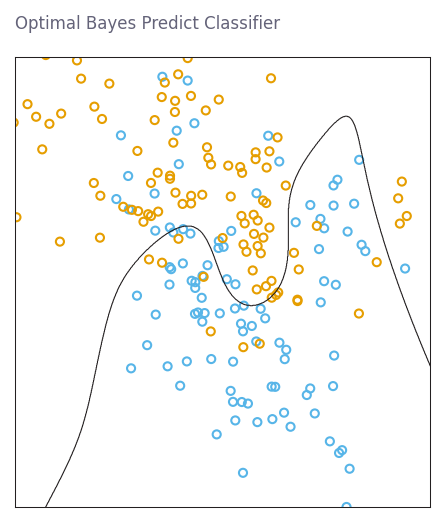

In [ ]:
""" Optimal Bayes Classifier with generated data """ 

""" Compute X points in a n1xn2 grid and the predicted classes """ 
def prediction_grid(n1, n2, predict_method):
  x1 = np.linspace(-2.8, 4.1, n1) 
  x2 = np.linspace(-2, 2.8, n2)
  X = np.transpose([np.tile(x1, n2), np.repeat(x2, n1)])
  y = predict_method(X)
  return X, y

def prediction_meshgrid(predict_method):
  n1, n2 = 1000, 1000
  X, y = prediction_grid(n1, n2, predict_method)
  return X[:,0].reshape(n1, n2), X[:,1].reshape(n1, n2), y.reshape(n1, n2)

def plot_model(predict_method, title):
  fig, ax = plot_training_data(title)
  """ add the decision boundary """ 
  x0_m, x1_m, y_m = prediction_meshgrid(predict_method)
  ax.contour(x0_m, x1_m, y_m, [0.5], colors=gray_, linewidths=[0.5])
  return fig, ax

__, __ = plot_model(optimal_bayes_predict, 'Optimal Bayes Predict Classifier')

In [ ]:
x0_bayes, x1_bayes, y_bayes = prediction_meshgrid(optimal_bayes_predict)
x0_bayes, x1_bayes, y_bayes

(array([[-2.8       , -2.79309309, -2.78618619, ...,  4.08618619,
          4.09309309,  4.1       ],
        [-2.8       , -2.79309309, -2.78618619, ...,  4.08618619,
          4.09309309,  4.1       ],
        [-2.8       , -2.79309309, -2.78618619, ...,  4.08618619,
          4.09309309,  4.1       ],
        ...,
        [-2.8       , -2.79309309, -2.78618619, ...,  4.08618619,
          4.09309309,  4.1       ],
        [-2.8       , -2.79309309, -2.78618619, ...,  4.08618619,
          4.09309309,  4.1       ],
        [-2.8       , -2.79309309, -2.78618619, ...,  4.08618619,
          4.09309309,  4.1       ]]),
 array([[-2.        , -2.        , -2.        , ..., -2.        ,
         -2.        , -2.        ],
        [-1.9951952 , -1.9951952 , -1.9951952 , ..., -1.9951952 ,
         -1.9951952 , -1.9951952 ],
        [-1.99039039, -1.99039039, -1.99039039, ..., -1.99039039,
         -1.99039039, -1.99039039],
        ...,
        [ 2.79039039,  2.79039039,  2.79039039, ...,  

In [ ]:
def plot_model_with_stats(predict_method, title):
  print('predict_method', predict_method)
  fig, ax = plot_model(predict_method, title)
  """ Bayes meshgrid for the optimal decision boundary""" 
  ax.contour(x0_bayes, x1_bayes, y_bayes, [0.5], 
             colors=gray_, linewidths=[0.5], linestyles='dashed')
  
  """ given the model prediction function plot the performance statistics """ 
  train_error_rate = 1 - accuracy_score(y_train, predict_method(X_train))
  test_error_rate = 1 - accuracy_score(y_test, predict_method(X_test))
  params_  = {'color' : gray_, 'fontsize': '6'}
  ax.text(-2.4, -1.4, f'Training Error: {train_error_rate:.2f}', **params_)
  ax.text(-2.4, -1.6, f'Training Error: {test_error_rate:.2f}', **params_) 
  ax.text(-2.4, -1.8, f'Bayes Error: {bayes_error_rate:.2f}', **params_)

  return fig, ax

### Linear Regression

predict_method <function linear_predict at 0x7ff950c69310>


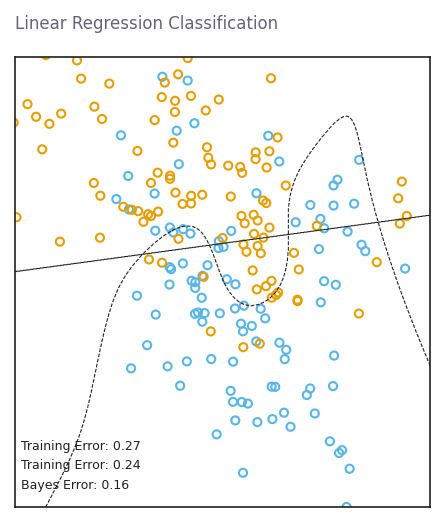

In [ ]:
from sklearn.linear_model import LinearRegression

""" produce the figures in the book of a linear model in classification context """ 
linear_regression_model = LinearRegression().fit(X_train, y_train)

def linear_predict(X):
  return 1*(linear_regression_model.predict(X) > 0.5)

_, _ = plot_model_with_stats(linear_predict, 'Linear Regression Classification')

### Nearest Neighbor Method

predict_method <bound method KNeighborsClassifier.predict of KNeighborsClassifier(n_neighbors=15)>


{'n_neighbors': 12}

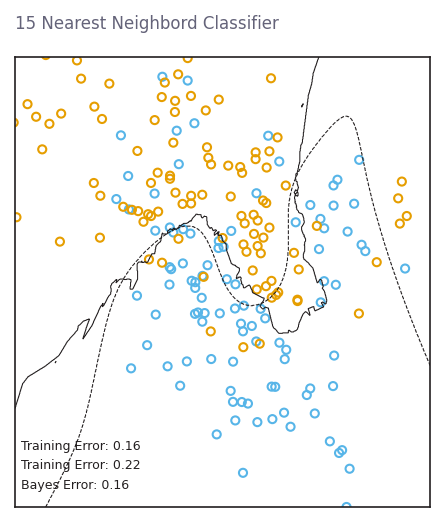

In [ ]:
""" 
Grid Search Cross Validationto find the best n_neighbors parameter 
using 10 fold cross validation. Use a 15-Nearest Neighbor Classifier 
"""
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
Kneighbors_GridSearch = GridSearchCV(
    KNeighborsClassifier(), 
    {'n_neighbors': list(range(1, 50))},
    cv=10
).fit(X_train, y_train).fit(X_train, y_train)

""" use neighbors15  averaging binary coded responses as method of fitting """ 
neighbors15_classifier = KNeighborsClassifier(
    n_neighbors=15
).fit(X_train, y_train)
_, _ = plot_model_with_stats(neighbors15_classifier.predict, '15 Nearest Neighbord Classifier')
Kneighbors_GridSearch.best_params_

predict_method <bound method KNeighborsClassifier.predict of KNeighborsClassifier(n_neighbors=1)>


{'n_neighbors': 12}

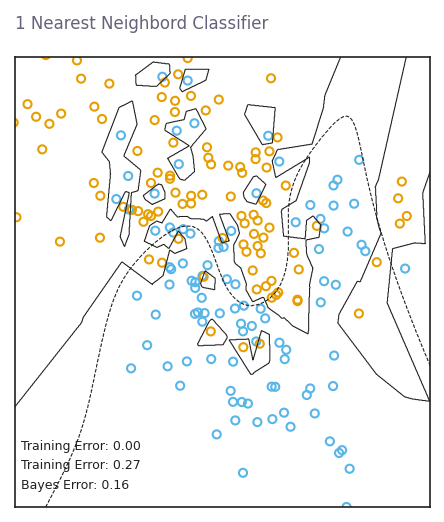

In [ ]:
""" classes coded as binary: 0 for set 1 (blue color) and 1 for set 2 (orange) 
    predicted by 1 nearest neighbor classifier """
   
Kneighbors_GridSearch = GridSearchCV(
    KNeighborsClassifier(), 
    {'n_neighbors': list(range(1, 50))},
    cv=10
).fit(X_train, y_train).fit(X_train, y_train)

neighbors1_classifier = KNeighborsClassifier(
    n_neighbors=1
).fit(X_train, y_train)
_, _ = plot_model_with_stats(
    neighbors1_classifier.predict, '1 Nearest Neighbord Classifier')
Kneighbors_GridSearch.best_params_

### Logistic Regression over Natural Cubic Spines

No Python library avaialble - implement it 

N_1(X) = 1, N_2(X) = X, N_k+2(X) d_k(X) - d_k-1(X)

d_k(X) = (X -eps_k)^3 - (X -eps_K)^3 / (eps_k - eps_K)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import itertools 

""" generate natural cubic pline and interaction features 
  - list of knots for each feature 
  - use either natural cubic splines or expnaded features interaction 
  - number of degrees of freedom for each feature 
  - for each feature indices of first and last """ 

""" transform data to natural cubic spline basic extension """ 

""" fit natural splines features model given the input training data 
    and other parameters as described, it returns predict data """ 



' fit natural splines features model given the input training data \n    and other parameters as described, it returns predict data '

In [ ]:
class NaturalCubicSplineFeatures(BaseEstimator, TransformerMixin):
  def __init__(self, knots=None, target_dof=None, add_interactions=False):
    self.knots = knots 
    self.target_dof = target_dof
    self.add_interactions = add_interactions
  
  def fit(self, X, y):

    if self.target_dof is not None:
      quantiles = np.linspace(0, 1, self.target_dof +1)
      self.knots = []
      for i in range(X.shape[1]):
        self.knots.append(np.unique(np.quantile(X[:, i], quantiles)))
    
    self.dofs_ = np.array([len(k)-1 for k in self.knots])
    dofs_csum = [0] + list(np.cumsum(self.dofs_))
    self.positions_ = \
        [(dofs_csum[i-1], dofs_csum[i]-1) \
            for i in range(1, len(dofs_csum))]
    return self

  def dk(X, knot, knot_last):
    dk_ = (X - knot).clip(0) **3 / (knot_last -knot)
    return dk_ 

  def expand_natural_cubic(self, X, knots):
    basis_splines = [X]
    dk_last = NaturalCubicSplineFeatures.dk(X, knots[-2], knots[-1])
    for knot in knots[:-2]:
      dk = NaturalCubicSplineFeatures.dk(X, knot, knots[-1])
      basis_splines.append(dk - dk_last)
    return np.hstack(basis_splines) 

  def add_interactions_features(self, features_basis_splines):
    features_indices = [list(range(exp_.shape[1]))
                            for exp_ in features_basis_splines]
    for cmb in itertools.product(*features_indices):
      prd = features_basis_splines[0][:, cmb[0]].copy()
      for i in range(1, len(cmb)):
        prd *= features_basis_splines[i][:, cmb[i]]
      features_basis_splines.append(np.atleast_2d(prd).T)
  
  def transform(self, X):
    features_basis_splines = []
    for i in range(X.shape[1]):
      features_basis_splines.append(
          self.expand_natural_cubic(X[:, i:i+1], self.knots[i]))
    if self.add_interactions:
      self.add_interactions_features(features_basis_splines)
    return np.hstack(features_basis_splines)


predict_method <bound method Pipeline.predict of Pipeline(steps=[('expand',
                 NaturalCubicSplineFeatures(knots=[array([-2,  0,  1,  3]),
                                                   array([-2,  0,  1,  3])])),
                ('scale', StandardScaler()),
                ('logistic', LogisticRegression())])>


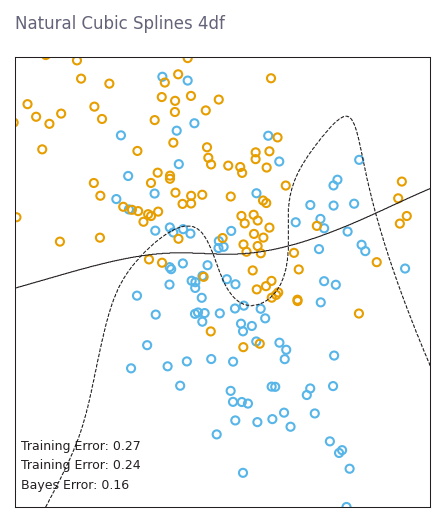

In [ ]:
knots = np.array([-2, 0, 1, 3])
""" 
upper panel using the decision boundary of the two coordinates 
df = 1 + (4 -1) + (4 -1) = 7; lower panel -  df =  4 x 4 = 16 
""" 
splines_log_regression = Pipeline([
    ('expand', NaturalCubicSplineFeatures([knots, knots])),
    ('scale', StandardScaler()),
    ('logistic', LogisticRegression(solver='lbfgs'))]
    ).fit(X_train, y_train) 

_, _ = plot_model_with_stats(
        splines_log_regression.predict, 'Natural Cubic Splines 4df ')

predict_method <bound method Pipeline.predict of Pipeline(steps=[('expand',
                 NaturalCubicSplineFeatures(add_interactions=True,
                                            knots=[array([-2,  0,  1,  3]),
                                                   array([-2,  0,  1,  3])])),
                ('scale', StandardScaler()),
                ('logistic', LogisticRegression())])>


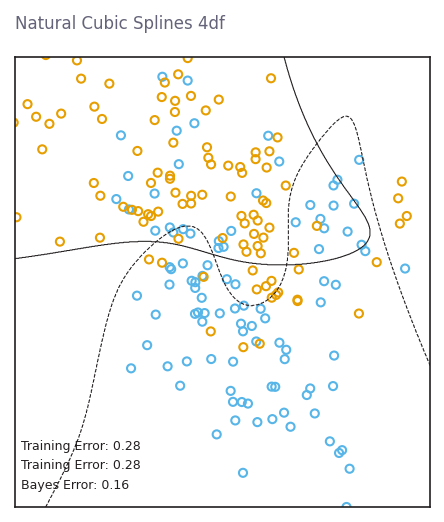

In [ ]:
splines_log_regression = Pipeline([
    ('expand', NaturalCubicSplineFeatures(knots=[knots, knots], add_interactions=True)),
    ('scale', StandardScaler()),
    ('logistic', LogisticRegression(solver='lbfgs'))]
    ).fit(X_train, y_train) 

_, _ = plot_model_with_stats(
        splines_log_regression.predict, 'Natural Cubic Splines 4df ')

### Neural Networks

In [ ]:
""" 
Pages 392-399
Scaling of the inputs determines the effective scaling of the weights in the 
bottom layer ~ use tensorflow for the final solution. 
All inputs treated equally for the regularization process, allow for 
meaningful rqndom starting weights.
For K classification, there are K units at the top, with k-th unit modeling  
the probability of the class k.
There are K target yk[1-k] each being coded as 0/1 variables for the kth class 
Feature Z created from linear combinations of the inputs, and target y modeled 
as a linear function of Z. The activation function is sigmoid. 
"""

step: 1, loss: 0.6489513566406486
step: 5, loss: 0.6233871697469276
step: 25, loss: 0.5540131958685943
step: 625, loss: 0.42386463520875595
step: 3125, loss: 0.24006975398456606
final step {step} final loss {current_loss}
predict_method <function run_train_data.<locals>.neural_network_predict at 0x7ff950dc4f70>


(<tf.Variable 'Variable_12:0' shape=(2, 10) dtype=float64_ref>,
 <tf.Variable 'Variable_13:0' shape=(1, 10) dtype=float64_ref>,
 <tf.Variable 'Variable_15:0' shape=(2,) dtype=float64_ref>,
 <tf.Tensor 'Placeholder_6:0' shape=(?, 2) dtype=float64>,
 <tf.Tensor 'Sigmoid_3:0' shape=(?, 10) dtype=float64>,
 <tf.Variable 'Variable_14:0' shape=(10, 2) dtype=float64_ref>,
 <tf.Tensor 'add_7:0' shape=(?, 2) dtype=float64>,
 <tf.Tensor 'Placeholder_7:0' shape=(?, 2) dtype=float64>,
 <tf.Tensor 'mul_3:0' shape=(?, 2) dtype=float64>,
 <tf.Tensor 'Mean_3:0' shape=() dtype=float64>,
 <tf.Operation 'Adam_3' type=NoOp>,
 2,
 <tf.Tensor 'Softmax_3:0' shape=(?, 2) dtype=float64>)

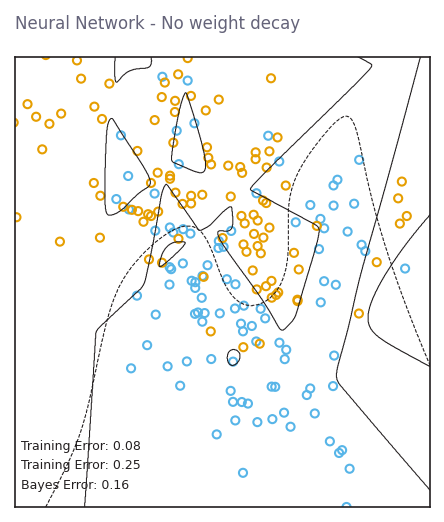

In [ ]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import tensorflow.compat.v1 as tf 
tf.disable_v2_behavior()

session = tf.Session()
initializer = tf.keras.initializers.glorot_uniform()
scaler = StandardScaler().fit(X_train)
X_train_standardized = scaler.transform(X_train)
y_train_onehot = OneHotEncoder(
    categories='auto').fit_transform(np.atleast_2d(y_train).T).toarray()

number_hidden = 10 
x = tf.placeholder(tf.float64, shape=[None, 2])
y = tf.placeholder(tf.float64, shape=[None, 2])

A = tf.Variable(initializer([2, number_hidden], dtype=tf.float64))
a0 = tf.Variable(initializer([1, number_hidden], dtype=tf.float64))
B = tf.Variable(initializer([number_hidden, 2], dtype=tf.float64))
b0 = tf.Variable(initializer([2], dtype=tf.float64))
Z = tf.nn.sigmoid(a0 + x@A)   
T = b0 + Z@B 
y_predict = tf.nn.softmax(T) 
cross_entropy = y*tf.log(y_predict) 
loss = tf.reduce_mean(-tf.reduce_sum(cross_entropy, reduction_indices=1))
feed_dictionary = {x: X_train_standardized, y: y_train_onehot}
adam_opt = tf.train.AdamOptimizer(1e-2).minimize(loss)

def run_train_data(optimizer_s, title):
  session.run(tf.global_variables_initializer())
  step = 0
  current_loss = session.run(loss, feed_dictionary)
  while step < 20000:
    step += 1 
    if math.log(step, 5).is_integer():
      print(f'step: {step}, loss: {current_loss}')
    session.run(optimizer_s, feed_dictionary)
    current_loss = session.run(loss, feed_dictionary)
  print('final step {step} final loss {current_loss}')

  def neural_network_predict(X):
      X = scaler.transform(X)
      return np.argmax(session.run(y_predict, {x:X}), axis=1) 
  plot_model_with_stats(neural_network_predict, title)

run_train_data(adam_opt, 'Neural Network - No weight decay')
A, a0, b0, x, Z, B, T, y, cross_entropy, loss, adam_opt, \
len(feed_dictionary), y_predict

### Support Vector Machines

predict_method <bound method BaseSVC.predict of SVC(C=10000, kernel='linear')>


(<Figure size 450x450 with 1 Axes>, <Axes: >)

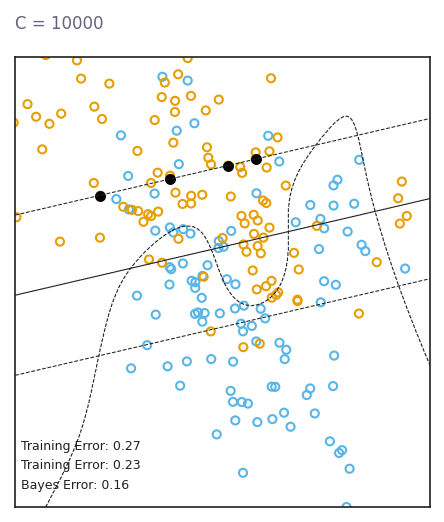

In [ ]:
""" Linear support vector boundary for the mixture data with two overlapping 
classes, two different values of C. The broken lines indicate the margins, 
where F(x) =+/-1, and the support points with ai > 0 are on the wrong side of 
the margin. The black solid dots are those support points falling exactly 
on the margin (epsi=0, ai >0)""" 

from sklearn.svm import SVC 
svc_model = SVC(
    C=10000, kernel="linear"
).fit(X_train, y_train)

def plot_svc_model(svc, title):
  support_vectors = abs(
      svc.decision_function(svc.support_vectors_))
  vectors = svc.support_vectors_[
      (support_vectors >0.99) & (support_vectors < 1.01)]
  fig, ax = plot_model_with_stats(svc.predict, title)
  x0, x1, y = prediction_meshgrid(svc.decision_function)
  ax.contour(x0, x1, y, [-1,1], colors=gray_, linewidths=[0.5, 0.5], 
            linestyles='dashed')
  ax.scatter(vectors[:, 0], vectors[:, 1], c='black', s=18)
  return fig, ax

plot_svc_model(svc_model, 'C = 10000 ')

predict_method <bound method BaseSVC.predict of SVC(C=0.01, kernel='linear')>


(<Figure size 450x450 with 1 Axes>, <Axes: >)

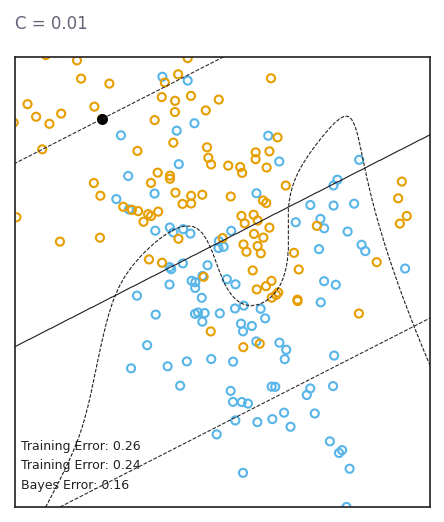

In [ ]:
svc_model_2 = SVC(
    C=0.01, kernel="linear"
).fit(X_train, y_train)
plot_svc_model(svc_model_2, 'C = 0.01 ')

predict_method <bound method BaseSVC.predict of SVC(C=10, coef0=7, degree=4, kernel='poly')>


(<Figure size 450x450 with 1 Axes>, <Axes: >)

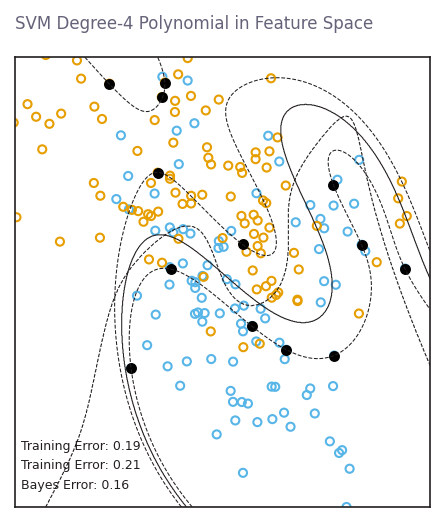

In [ ]:
svc_poly = SVC(
    kernel='poly', degree=4, coef0=7, C=10
).fit(X_train, y_train)
plot_svc_model(svc_poly, 'SVM Degree-4 Polynomial in Feature Space ')

predict_method <bound method BaseSVC.predict of SVC(gamma=1)>


(<Figure size 450x450 with 1 Axes>, <Axes: >)

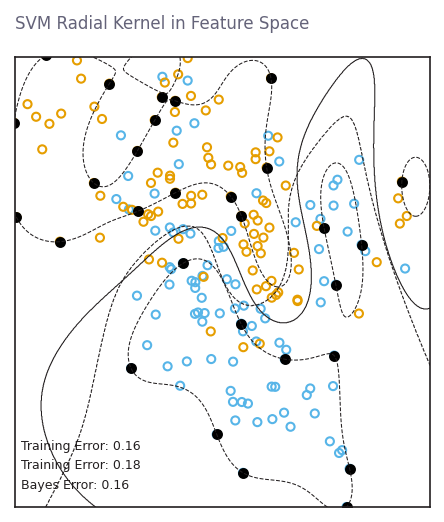

In [ ]:
svc_rbf = SVC(
    kernel='rbf', gamma=1
).fit(X_train, y_train)
plot_svc_model(svc_rbf, 'SVM Radial Kernel in Feature Space ')

### Flexible Discriminant Analysis

Two versions: 
- FDA/MARS (Earth Data)
- Mixture Discriminant Analysis


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.multiclass import unique_labels
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import multivariate_normal 

""" Classifier with nonlinear decision boundary, with each class 
represented as a mixture of components """ 
class MixtureDiscriminantAnalysis(BaseEstimator, TransformerMixin):
  def __init__(self, n_prototypes, max_iter, random_state):
    self.n_prototypes = n_prototypes
    self.max_iter = max_iter
    self.random_state = random_state 
  
  def fit(self, X, y):
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    self.classes_ = label_encoder.classes_
    N, p, K = *X.shape, self.classes_.size 
    _, counts = np.unique(y, return_counts=True) 
    self.priors_ = counts/len(y)
    np.random.seed(self.random_state)
    means = np.stack(
        [np.vstack([np.quantile(
          X[y == k][:, i], np.random.uniform(0, 1, self.n_prototypes))
          for i in range(p)]).T 
        for k in range(K)]) 
    abs_prototypes = np.zeros(shape=N, dtype=int)
    for i in range(N):
      abs_prototypes[i] = np.argmin(np.sum( (means[y[i]] -X[i])**2, axis=1))
    mixin_proportions = np.stack(
          [np.bincount(abs_prototypes[y == k]) / np.sum(y == k)
          for k in range(K)]) 
    cov = np.zeros(shape=(p, p))
    for k in range(K):
      for r in range(self.n_prototypes):
        Xkr = X[(y == k) & (abs_prototypes == r), :]
        cov += mixin_proportions[k, r] * \
                self.priors_[k] * np.cov(Xkr.T, bias=True)
    for step in range(self.max_iter):
      responsibilities = self.__e_step(N, X, cov, means, mixin_proportions, y)
      cov, means, mixin_proportions = self.__m_step(N,X,p,responsibilities, y)
    self.means_ = means 
    self.mixin_proportions_ = mixin_proportions
    self.cov_ = cov 
    return self 

  def __e_step(self, N, X, cov, means, mixin_proportions, y):
    responsibilities = np.zeros((N, self.n_prototypes))
    for i in range(N):
      k = y[i] 
      for r in range(self.n_prototypes):
        probabilities = multivariate_normal.pdf(X[i], means[k, r], cov)
        responsibilities[i, r] = mixin_proportions[k, r] * probabilities
      responsibilities[i] /= np.sum(responsibilities[i]) 
    return responsibilities

  def __m_step(self, N, X, p, responsibilities, y):
    K = self.classes_.size 
    means = np.zeros(shape=(K, self.n_prototypes, p))
    cov = np.zeros(shape=(p, p))
    mixin_proportions = np.zeros(shape=(K, self.n_prototypes))
    for k in range(K):
      Xk, class_responsibility, = X[y == k], responsibilities[y == k]
      for r in range(self.n_prototypes):
        prototype_responsibility = class_responsibility[:, r:r+1]
        mixin_proportions[k, r] = np.sum(prototype_responsibility)/Xk.shape[0]
        means[k, r] = np.sum(Xk*prototype_responsibility, axis=0) \
                              / np.sum(prototype_responsibility)
    for i in range(N):
      for r in range(self.n_prototypes):
        vector = np.atleast_2d(X[i] - means[y[i], r]).T 
        cov += responsibilities[i, r] * (vector @vector.T)
    cov /= N 
    return cov, means, mixin_proportions

  def predict_proba(self, X):
    K = self.classes_.size
    prototype_proba = np.zeros((X.shape[0], K, self.n_prototypes))
    for k in range(K):
      for r in range(self.n_prototypes): 
        probability = self.mixin_proportions_[k, r] * multivariate_normal.pdf(
            X, self.means_[k, r], self.cov_) * self.priors_[k]
        prototype_proba[:, k, r] = probability
    
    proba = np.sum(prototype_proba, axis=2)
    denominators = np.sum(proba, axis=1)
    proba /= denominators[:, None]
    return proba 

  def predict(self, X):
    return self.classes_[np.argmax(self.predict_proba(X), axis=1)] 


In [ ]:
""" explain in details each step to complete the model as in the book """ 

predict_method <bound method MixtureDiscriminantAnalysis.predict of MixtureDiscriminantAnalysis(max_iter=100, n_prototypes=5, random_state=30)>


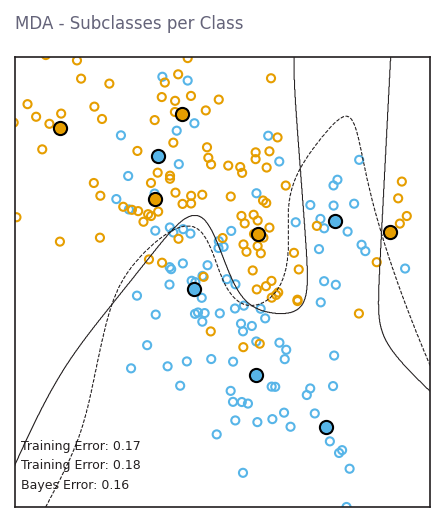

In [ ]:
mda_model = MixtureDiscriminantAnalysis(5, 100, 30).fit(X_train, y_train)
fig, ax = plot_model_with_stats(mda_model.predict, 'MDA - Subclasses per Class')
ax.scatter(mda_model.means_[0][:,0], mda_model.means_[0][:,1], s = 40, facecolors=blue_, edgecolors='black') 
ax.scatter(mda_model.means_[1][:,0], mda_model.means_[1][:,1], s = 40, facecolors=orange_, edgecolors='black') 

predict_method <bound method MixtureDiscriminantAnalysis.predict of MixtureDiscriminantAnalysis(max_iter=100, n_prototypes=5, random_state=30)>


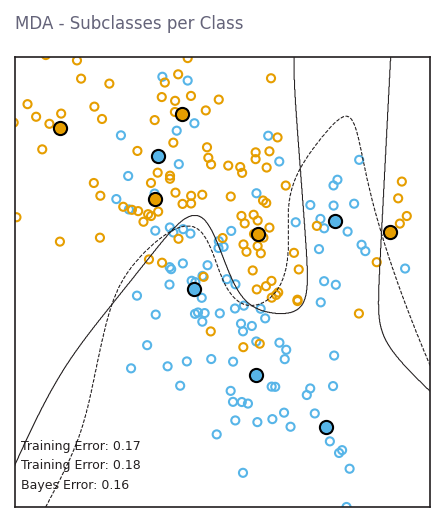

In [ ]:
def plot_protoype_model(predict_method, title, set1, set2):
  fig, ax = plot_model_with_stats(predict_method, title)
  ax.scatter(set1[:,0], set1[:,1], s = 40, facecolors=blue_, edgecolors='black') 
  ax.scatter(set2[:,0], set2[:,1], s = 40, facecolors=orange_, edgecolors='black') 

plot_protoype_model(mda_model.predict, 'MDA - Subclasses per Class', 
                    mda_model.means_[0], mda_model.means_[1])

### Prototypes and Nearest Neighbors

In [ ]:
from sklearn.cluster import KMeans 
kmeans_set1 = KMeans(n_clusters=5).fit(X_test[y_test == 0])
kmeans_set2 = KMeans(n_clusters=5).fit(X_test[y_test == 1])

def k_means_predict(X): 
 return np.argmin(
          np.vstack((np.min(kmeans_set1.transform(X), axis=1), 
                     np.min(kmeans_set2.transform(X), axis=1))), 
          axis=1)
 

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
#plot_protoype_model(k_means_predict, 'K-means  - 5 Prototypes per Class', 
#                    kmeans_set1.cluster_centers_, kmeans_set2.cluster_centers_)
kmeans_set1.cluster_centers_

array([[ 0.22206913,  0.02328093],
       [ 2.45171089,  0.9478207 ],
       [ 1.75553969, -0.21527608],
       [ 0.77356894, -1.13302143],
       [-0.2003781 ,  1.02797617]])

In [ ]:
np.min(kmeans_set1.transform(X)),  np.min(kmeans_set2.transform(X))

(0.009960753746404833, 0.008172569717053504)

In [ ]:
vstack_ = np.vstack((np.min(kmeans_set1.transform(X), axis=1), 
                     np.min(kmeans_set2.transform(X), axis=1))),
vstack_[0]

array([[3.80465442, 3.71787909, 3.6319483 , ..., 2.05214923, 2.12091754,
        2.19236396],
       [3.1518552 , 3.10380702, 3.05846997, ..., 1.29289585, 1.31852968,
        1.35153806]])

In [ ]:
np.argmin(
          np.vstack((np.min(kmeans_set1.transform(X), axis=1), 
                     np.min(kmeans_set2.transform(X), axis=1))), 
          axis=1)

array([4469, 4042])

(6831,) GaussianMixture(covariance_type='spherical', n_components=5, random_state=1)
predict_method <function gaussian_mixture_predict at 0x7ff75f239790>


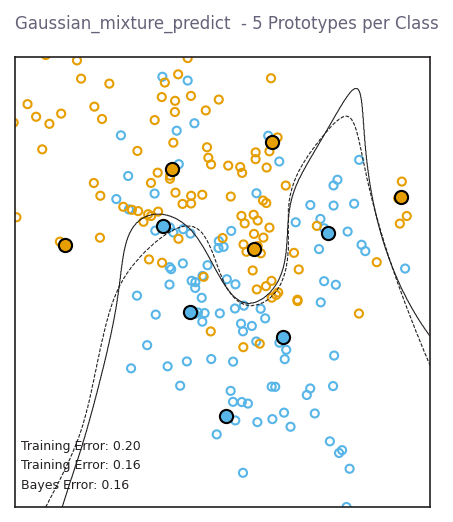

In [ ]:
gaussian_mixture_set1 = GaussianMixture(
    n_components=5, covariance_type='spherical', random_state=1
).fit(X_test[y_test == 0])
gaussian_mixture_set2 = GaussianMixture(
    n_components=5, covariance_type='spherical', random_state=1
).fit(X_test[y_test == 1])

def gaussian_mixture_predict(X):
  rvs_set1 = [(gaussian_mixture_set1.weights_[i], 
               multivariate_normal(gaussian_mixture_set1.means_[i], 
                                   gaussian_mixture_set1.covariances_[i]))
               for i in range(5)]
  rvs_set2 = [(gaussian_mixture_set2.weights_[i], 
               multivariate_normal(gaussian_mixture_set2.means_[i], 
                                   gaussian_mixture_set2.covariances_[i]))
               for i in range(5)] 
  p_set1 = np.sum(np.array([rvs[0]*rvs[1].pdf(X) for rvs in rvs_set1]), axis=0)
  p_set2 = np.sum(np.array([rvs[0]*rvs[1].pdf(X) for rvs in rvs_set2]), axis=0)
  y = 1*(p_set1 < p_set2)
  return y 

print(gaussian_mixture_predict(X).shape, gaussian_mixture_set1)
plot_protoype_model(gaussian_mixture_predict, 
                    'Gaussian_mixture_predict  - 5 Prototypes per Class', 
                    gaussian_mixture_set1.means_, gaussian_mixture_set2.means_)

### K Nearest Neighbors

predict_method <bound method KNeighborsClassifier.predict of KNeighborsClassifier(n_neighbors=7)>


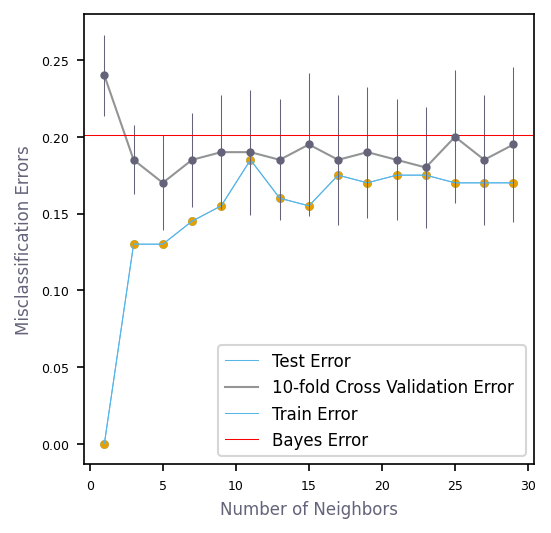

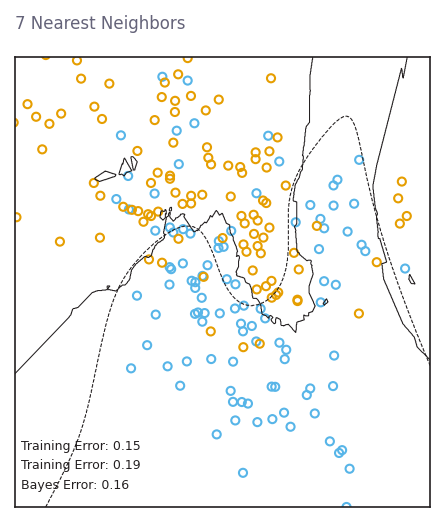

In [ ]:
n_neigbors_values = list(range(1, 30, 2))
k_neighbors_grid_search = GridSearchCV(
    KNeighborsClassifier(), 
    {'n_neighbors': n_neigbors_values}, 
    cv=10, scoring='accuracy', return_train_score=True, 
).fit(X_train, y_train)

train_errors, test_errors = [], []
for k in n_neigbors_values:
  classifier_ = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
  train_errors.append(1 - classifier_.score(X_train, y_train))
  test_errors.append(1 - classifier_.score(X_train, y_train))
cv_errors = 1 - np.vstack([
  k_neighbors_grid_search.cv_results_[f'split{i}_test_score'] for i in range(10)]).T 
cv_mean_errors = np.mean(cv_errors, axis=1)
cv_std_errors = np.std(cv_errors, ddof=1, axis=1) /np.sqrt(10)
best_index = np.argmin(cv_mean_errors)
best_error, best_std_error = cv_mean_errors[best_index], cv_std_errors[best_index]
fig, ax = plt.subplots(figsize=(3,3), dpi=150)
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax.scatter(n_neigbors_values, test_errors, c=blue_, s=10)
ax.plot(n_neigbors_values, test_errors, c=blue_, linewidth=0.5, label='Test Error')
ax.plot(n_neigbors_values, cv_mean_errors, c=gray___, linewidth=1, 
        label='10-fold Cross Validation Error ')
ax.scatter(n_neigbors_values, train_errors, c=orange_, s=10)
ax.plot(n_neigbors_values, train_errors, c=blue_, linewidth=0.5, label='Train Error')
ax.errorbar(n_neigbors_values, cv_mean_errors, color=gray__, 
            linestyle='None', marker='o', elinewidth=0.5, 
            markersize=3, yerr=cv_std_errors)
ax.axhline(y=best_error+best_std_error, c='red', linewidth=0.5, label='Bayes Error')
for i in ax.get_yticklabels() + ax.get_xticklabels():
  i.set_fontsize(6)
ax.set_xlabel('Number of Neighbors', color=gray__, fontsize=8)
ax.set_ylabel('Misclassification Errors', color=gray__, fontsize=8)
neighbors7_classifier = KNeighborsClassifier(n_neighbors=7).fit(X_train, y_train)
plot_model_with_stats(neighbors7_classifier.predict, '7 Nearest Neighbors ')
ax.legend(loc='lower right', prop={'size': 8})

### Random Forest

predict_method <bound method ForestClassifier.predict of RandomForestClassifier(n_estimators=35, oob_score=True, random_state=0)>
predict_method <bound method KNeighborsClassifier.predict of KNeighborsClassifier(n_neighbors=3)>


(<Figure size 450x450 with 1 Axes>, <Axes: >)

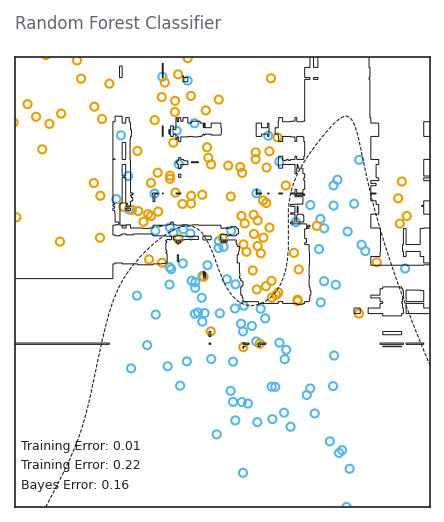

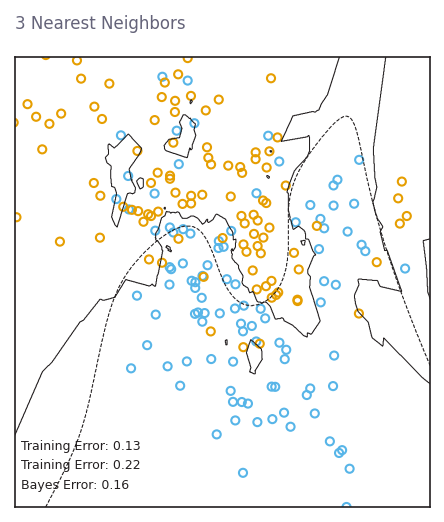

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import MDS 
random_forest_classifier = RandomForestClassifier(
    n_estimators=35, random_state=0, oob_score=True
).fit(X_train, y_train)
neigbbors3_classifier = KNeighborsClassifier(
    n_neighbors=3, 
).fit(X_train, y_train)
plot_model_with_stats(
    random_forest_classifier.predict, 'Random Forest Classifier'
)
plot_model_with_stats(
    neigbbors3_classifier.predict, '3 Nearest Neighbors'
)

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


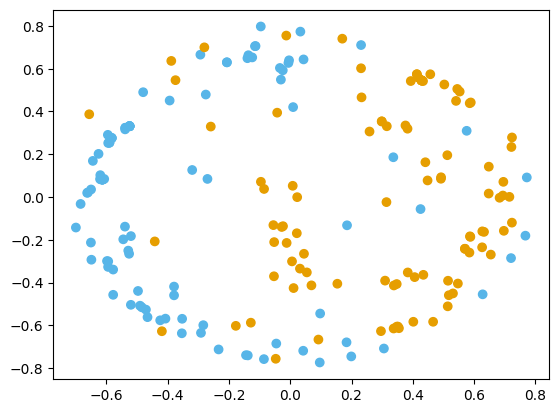

predict_method <bound method ForestClassifier.predict of RandomForestClassifier(n_estimators=35, oob_score=True, random_state=0)>


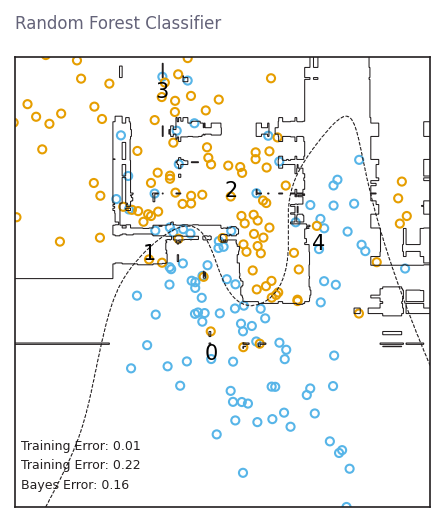

In [ ]:
leaf_ids = random_forest_classifier.apply(X_train)
N = X_train.shape[0]
proximity_matrix = np.zeros((N,N))
for i in range(leaf_ids.shape[1]):
  tree_leaf_ids = leaf_ids[:, i]
  proximity_matrix += np.equal.outer(tree_leaf_ids, tree_leaf_ids)
proximity_matrix /= leaf_ids.shape[1]

multidimensional_scaling = MDS(
    n_components=2, dissimilarity='precomputed', random_state=1
).fit_transform(1 - proximity_matrix)
centers = KMeans(n_clusters=5).fit(multidimensional_scaling).cluster_centers_
closest_idx = [np.argmin(np.sum((
        multidimensional_scaling - centers[i])**2, axis=1)) for i in range(5)]
multidimensional_scaling_points = multidimensional_scaling[closest_idx] 
obs_points = X_train[closest_idx]

plt.scatter(multidimensional_scaling[:,0], multidimensional_scaling[:,1], 
            c = np.array([blue_, orange_])[y_train])
plt.show()
fig, ax = plot_model_with_stats(random_forest_classifier.predict, 
                                'Random Forest Classifier')
for i in range(5): 
  ax.annotate(f'{i}', obs_points[i], ha='center', color='black')